In [43]:
import tensorflow as tf
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

In [44]:
# Function to preprocess TIFF images
def preprocess_tiff(image_path, target_size):
    with rasterio.open(image_path) as src:
        red_band = src.read(4)  # Band 4
        green_band = src.read(3)  # Band 3
        blue_band = src.read(2)  # Band 2
        rgb_image = np.dstack((red_band, green_band, blue_band))
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1
    return rgb_image

In [45]:
# Function to load and preprocess standard images
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0 to 1
    return image

In [46]:
# Function to preprocess both high and low resolution images along with land cover band
def preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size):
    hr_image_path = os.path.join(hr_dir, hr_file)
    base_name = hr_file.replace('_rgb.png', '')
    
    # Load high-resolution image (RGB)
    hr_image = load_image(hr_image_path)
    
    # Load low-resolution image (L2A_data.tiff)
    lr_image_file = f"{base_name}-L2A_data.tiff"
    lr_image_path = os.path.join(lr_dir, lr_image_file)
    lr_image = preprocess_tiff(lr_image_path, target_size)
    
    # Load landcover band
    lc_image_file = f"{base_name}.tif"
    lc_image_path = os.path.join(lc_dir, lc_image_file)
    with rasterio.open(lc_image_path) as src:
        lc_band = src.read(1)
        lc_band = cv2.resize(lc_band, target_size, interpolation=cv2.INTER_CUBIC)
        lc_band = np.expand_dims(lc_band, axis=-1)
        lc_band = np.clip(lc_band, 0, 255) / 255.0  # Normalize to 0 to 1
    
    # Ensure low-resolution image is in the correct range
    lr_image = np.clip(lr_image, 0, 1)
    
    # Concatenate the landcover band to the RGB images
    hr_image = np.concatenate((hr_image, lc_band), axis=-1)
    lr_image = np.concatenate((lr_image, lc_band), axis=-1)
    
    return hr_image, lr_image

In [47]:
# Function to create dataset from high and low resolution images
def create_dataset(lr_dir, hr_dir, lc_dir, target_size=(1054, 1054)):
    hr_image_files = [f for f in os.listdir(hr_dir) if f.endswith('_rgb.png') and not f.startswith('.')]
    hr_images = []
    lr_images = []

    for hr_file in hr_image_files:
        hr_image, lr_image = preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size)
        hr_images.append(hr_image)
        lr_images.append(lr_image)

    return np.array(hr_images), np.array(lr_images)

In [48]:
# Paths to directories
hr_dir = 'high_resolution_final'
lr_dir = 'low_resolution_final'
lc_dir = 'land_cover_final'

# Create dataset
hr_images, lr_images = create_dataset(lr_dir, hr_dir, lc_dir)

In [50]:
# Get the size of the numpy arrays in bytes
hr_images_size_bytes = hr_images.nbytes
lr_images_size_bytes = lr_images.nbytes

In [51]:
# Convert sizes to MB for readability
hr_images_size_mb = hr_images_size_bytes / (1024 * 1024)
lr_images_size_mb = lr_images_size_bytes / (1024 * 1024)

# Convert sizes to GB for readability
hr_images_size_gb = hr_images_size_mb / 1024
lr_images_size_gb = lr_images_size_mb / 1024

print(f"High-resolution images array size: {hr_images_size_gb:.2f} GB")
print(f"Low-resolution images array size: {lr_images_size_gb:.2f} GB")

High-resolution images array size: 71.51 GB
Low-resolution images array size: 35.76 GB


In [52]:
# Function to check data
def check_data(hr_images, lr_images):
    for i in range(min(4, len(hr_images))):
        hr_image = hr_images[i]
        lr_image = lr_images[i]
        
        print(f"High-resolution image {i}: shape={hr_image.shape}, min={hr_image.min()}, max={hr_image.max()}")
        print(f"Low-resolution image {i}: shape={lr_image.shape}, min={lr_image.min()}, max={lr_image.max()}")
        print("")

# Check data
check_data(hr_images, lr_images)

High-resolution image 0: shape=(1054, 1054, 4), min=0.0, max=1.0
Low-resolution image 0: shape=(1054, 1054, 4), min=0.0003948086523450911, max=0.002181642223149538

High-resolution image 1: shape=(1054, 1054, 4), min=0.0, max=1.0
Low-resolution image 1: shape=(1054, 1054, 4), min=0.0002412636240478605, max=0.002826261566951871

High-resolution image 2: shape=(1054, 1054, 4), min=0.0, max=1.0
Low-resolution image 2: shape=(1054, 1054, 4), min=0.00023332842101808637, max=0.002227726159617305

High-resolution image 3: shape=(1054, 1054, 4), min=0.0, max=1.0
Low-resolution image 3: shape=(1054, 1054, 4), min=0.00039458772516809404, max=0.002514402847737074



In [53]:
# Generator class for training data
class DataGenerator(Sequence):
    def __init__(self, lr_images, hr_images, batch_size=8, target_size=(1054, 1054)):
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.lr_images))
        
    def __len__(self):
        return int(np.floor(len(self.lr_images) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        lr_batch = np.array([self.lr_images[i] for i in indices])
        hr_batch = np.array([self.hr_images[i] for i in indices])
        return lr_batch, hr_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    
    def get_info(self):
        info = {
            'num_samples': len(self.lr_images),
            'batch_size': self.batch_size,
            'num_batches': self.__len__(),
            'image_shape': self.lr_images[0].shape if len(self.lr_images) > 0 else None,
        }
        return info

# Split the data into training and testing sets
train_hr_images, test_hr_images, train_lr_images, test_lr_images = train_test_split(hr_images, lr_images, test_size=0.2, random_state=42)

# Create data generators
train_generator = DataGenerator(train_lr_images, train_hr_images, batch_size=8)
test_generator = DataGenerator(test_lr_images, test_hr_images, batch_size=8)

# Print dataset information
train_info = train_generator.get_info()
test_info = test_generator.get_info()

print("Training Dataset Info:")
print(f"Number of samples: {train_info['num_samples']}")
print(f"Batch size: {train_info['batch_size']}")
print(f"Number of batches: {train_info['num_batches']}")
print(f"Image shape: {train_info['image_shape']}")

print("\nTesting Dataset Info:")
print(f"Number of samples: {test_info['num_samples']}")
print(f"Batch size: {test_info['batch_size']}")
print(f"Number of batches: {test_info['num_batches']}")
print(f"Image shape: {test_info['image_shape']}")

Training Dataset Info:
Number of samples: 1728
Batch size: 8
Number of batches: 216
Image shape: (1054, 1054, 4)

Testing Dataset Info:
Number of samples: 432
Batch size: 8
Number of batches: 54
Image shape: (1054, 1054, 4)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

# Create and compile the model
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(None, None, 4)))  # 4 channels: RGB + landcover band
    model.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(4, (5, 5), activation='linear', padding='same'))  # Output 4 channels
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', psnr_metric, ssim_metric])
    return model

# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 64)    20800     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 32)    2080      
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 4)     3204      
                                                                 
Total params: 26,084
Trainable params: 26,084
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [19]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, mse, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test MSE: {mse}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Save the model
model.save('srcnn_model.h5')

Epoch 1/10
216/216 [==============================] - 8141s 38s/step - loss: 0.0167 - mse: 0.0167 - psnr_metric: 20.8557 - ssim_metric: 0.6380 - val_loss: 0.0131 - val_mse: 0.0131 - val_psnr_metric: 22.2508 - val_ssim_metric: 0.6672
Epoch 2/10
216/216 [==============================] - 8091s 37s/step - loss: 0.0146 - mse: 0.0146 - psnr_metric: 21.5156 - ssim_metric: 0.6513 - val_loss: 0.0122 - val_mse: 0.0122 - val_psnr_metric: 21.1580 - val_ssim_metric: 0.6494
Epoch 3/10
216/216 [==============================] - 8083s 37s/step - loss: 0.0132 - mse: 0.0132 - psnr_metric: 22.2064 - ssim_metric: 0.6629 - val_loss: 0.0137 - val_mse: 0.0137 - val_psnr_metric: 19.8256 - val_ssim_metric: 0.6266
Epoch 4/10
216/216 [==============================] - 8088s 37s/step - loss: 0.0129 - mse: 0.0129 - psnr_metric: 22.0866 - ssim_metric: 0.6639 - val_loss: 0.0111 - val_mse: 0.0111 - val_psnr_metric: 23.6574 - val_ssim_metric: 0.6990
Epoch 5/10
216/216 [==============================] - 8043s 37s/step

In [31]:
!pip install pydot graphviz

Keyring is skipped due to an exception: 'keyring.backends'
Defaulting to user installation because normal site-packages is not writeable


In [26]:
import pydot
import graphviz

In [32]:
from tensorflow.keras.utils import plot_model

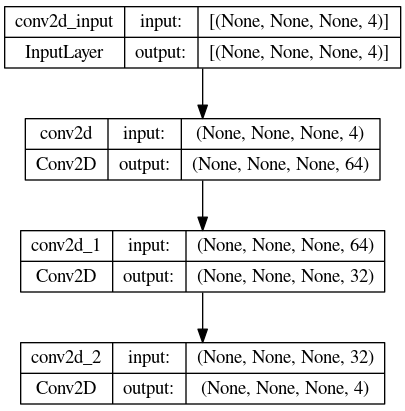

In [34]:
from tensorflow.keras.models import load_model

# Load the model with custom metrics
model = load_model('srcnn_model.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

plot_model(model, to_file='srcnn.png', show_shapes=True)

Loading low-resolution image from low_resolution_final/Landcover-768945-L2A_data.tiff
Loading land cover image from land_cover_final/Landcover-768945.tif


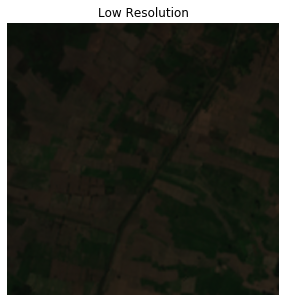

Loading low-resolution image from low_resolution_final/Landcover-768945-L2A_data.tiff
Loading land cover image from land_cover_final/Landcover-768945.tif
1/1 [==============================] - 1s 631ms/step
Loading high-resolution image from high_resolution_final/Landcover-768945_rgb.png
High-resolution image shape: (1054, 1054, 3)


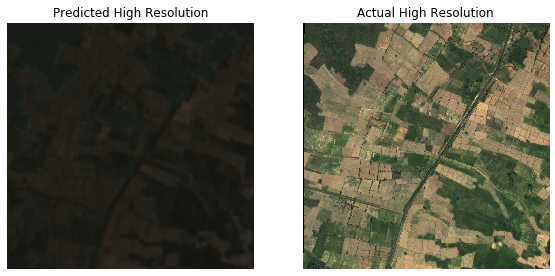

In [36]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt

# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Load the model with custom metrics
model = load_model('srcnn_model.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

# Function to preprocess a single low-resolution image and land cover band
def preprocess_single_image(image_path, landcover_path, target_size=(1054, 1054), normalize=False):
    print(f"Loading low-resolution image from {image_path}")
    with rasterio.open(image_path) as src:
        red_band = src.read(4)  # Band 4
        green_band = src.read(3)  # Band 3
        blue_band = src.read(2)  # Band 2
        rgb_image = np.dstack((red_band, green_band, blue_band))
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)

        if normalize:
            rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1

    print(f"Loading land cover image from {landcover_path}")
    # Load and preprocess the land cover band
    with rasterio.open(landcover_path) as src:
        landcover_image = src.read(1)
        landcover_image = cv2.resize(landcover_image, target_size, interpolation=cv2.INTER_NEAREST)
        landcover_image = np.expand_dims(landcover_image, axis=-1)
        
        if normalize:
            landcover_image = landcover_image / 255.0  # Normalize to 0 to 1
    
    # Concatenate the land cover band to the RGB image
    combined_image = np.concatenate((rgb_image, landcover_image), axis=-1)
    
    return combined_image

# Function to load high-resolution image
def load_high_res_image(image_path):
    print(f"Loading high-resolution image from {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"High-resolution image file {image_path} could not be loaded.")
    print(f"High-resolution image shape: {image.shape}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0 to 1
    return image

# Paths to the low-resolution and high-resolution images
low_res_image_path = 'low_resolution_final/Landcover-768945-L2A_data.tiff'
landcover_image_path = 'land_cover_final/Landcover-768945.tif'
high_res_image_path = 'high_resolution_final/Landcover-768945_rgb.png'

# Preprocess the low-resolution image without normalization for viewing
lr_image_non_normalized = preprocess_single_image(low_res_image_path, landcover_image_path, normalize=False)

# Plot the low-resolution image without normalization
plt.figure(figsize=(10, 5))
plt.imshow(lr_image_non_normalized[:, :, :3])  # Display only the RGB channels
plt.title('Low Resolution')
plt.axis('off')
plt.show()

# Preprocess the low-resolution image with normalization for prediction
lr_image_normalized = preprocess_single_image(low_res_image_path, landcover_image_path, normalize=True)

# Predict the high-resolution image using the model
lr_image_expanded = np.expand_dims(lr_image_normalized, axis=0)  # Expand dimensions to match model input shape
predicted_hr_image = model.predict(lr_image_expanded)[0]  # Predict and remove batch dimension

# Load the actual high-resolution image
hr_image = load_high_res_image(high_res_image_path)

# Plot the images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
plt.imshow(predicted_hr_image[:, :, :3])  # Display only the RGB channels
plt.title('Predicted High Resolution')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_image)
plt.title('Actual High Resolution')
plt.axis('off')

plt.show()

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model():
    model1 = Sequential()
    model1.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(1054, 1054, 3)))
    model1.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
    model1.add(Conv2D(3, (5, 5), activation='linear', padding='same'))
    model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model1

model1 = create_model()
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 1054, 1054, 64)    15616     
                                                                 
 conv2d_16 (Conv2D)          (None, 1054, 1054, 32)    2080      
                                                                 
 conv2d_17 (Conv2D)          (None, 1054, 1054, 3)     2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_1.h5', save_best_only=True, monitor='val_loss')

In [58]:
# Train the model
history = model1.fit(train_generator, epochs=1, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, mse, psnr, ssim = model1.evaluate(test_generator)
print(f"Test Loss: {loss}, Test MSE: {mse}, Test PSNR: {psnr}, Test SSIM: {ssim}")

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_5/conv2d_15/Relu' defined at (most recent call last):
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
      app.start()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
      self.io_loop.start()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
      self.asyncio_loop.run_forever()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
      self._run_once()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
      handle._run()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
      user_expressions, allow_stdin,
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
      return runner(coro)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/shared/centos7/anaconda3/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-57-e3c8347077d2>", line 2, in <module>
      history = model1.fit(train_generator, epochs=1, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "/home/zhou.hanyi/.local/lib/python3.7/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_5/conv2d_15/Relu'
input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node sequential_5/conv2d_15/Relu}}]] [Op:__inference_train_function_7655]

54/54 [==============================] - 775s 14s/step - loss: 0.0096 - mse: 0.0096 - psnr_metric: 23.2908 - ssim_metric: 0.6880
Test Loss: 0.009565139189362526, Test MSE: 0.009565138258039951, Test PSNR: 23.290782928466797, Test SSIM: 0.6880220770835876
54/54 [==============================] - 263s 5s/step


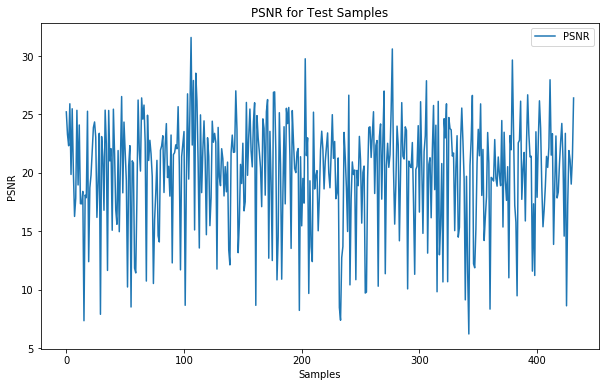

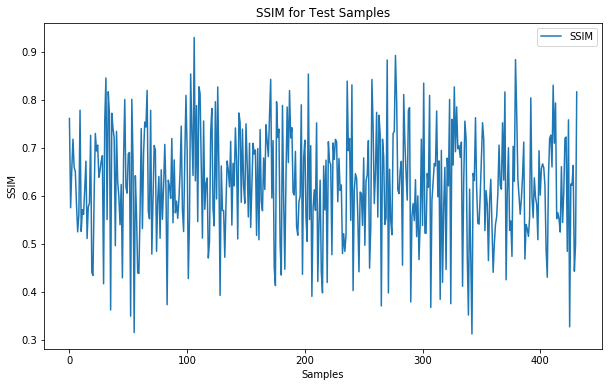

ValueError: x and y can be no greater than 2-D, but have shapes (432,) and (432, 1054, 1054)

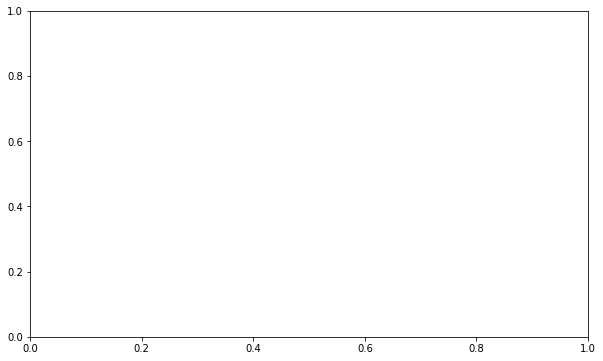

In [61]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Custom metric functions
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32), max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32), max_val=1.0)

# Load the saved model
model = load_model('srcnn_model.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

# Evaluate the model
loss, mse, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test MSE: {mse}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Get predictions for the test dataset
y_pred = model.predict(test_generator)
y_true = np.concatenate([y for x, y in test_generator], axis=0)

# Plot PSNR graph
psnr_values = [psnr_metric(y_true[i], y_pred[i]).numpy() for i in range(len(y_true))]
plt.figure(figsize=(10, 6))
plt.plot(psnr_values, label='PSNR')
plt.xlabel('Samples')
plt.ylabel('PSNR')
plt.title('PSNR for Test Samples')
plt.legend()
plt.show()

# Plot SSIM graph
ssim_values = [ssim_metric(y_true[i], y_pred[i]).numpy() for i in range(len(y_true))]
plt.figure(figsize=(10, 6))
plt.plot(ssim_values, label='SSIM')
plt.xlabel('Samples')
plt.ylabel('SSIM')
plt.title('SSIM for Test Samples')
plt.legend()
plt.show()




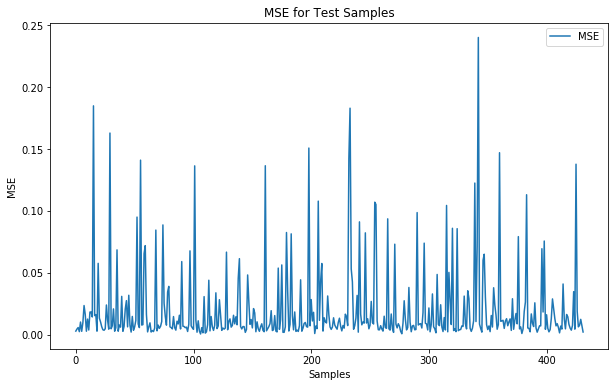

In [62]:
# Calculate mean MSE for each sample and plot MSE graph
mse_values = [tf.keras.losses.mean_squared_error(y_true[i], y_pred[i]).numpy().mean() for i in range(len(y_true))]
plt.figure(figsize=(10, 6))
plt.plot(mse_values, label='MSE')
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.title('MSE for Test Samples')
plt.legend()
plt.show()